In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict
from sklearn.metrics import confusion_matrix
from scikitplot.metrics import plot_roc

from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Data Import and Preparation - uso SAX perchè originale troppo grande

In [2]:
# faccio l'import del dataset approssimato perché quello originale mi da problemi di esecuzione con il kernel --> SAX
X_train=np.load('X_train_sax.npy')
X_train=np.squeeze(X_train)
X_train, X_train.shape

(array([[25, 24, 24, ..., 25, 24, 24],
        [24, 25, 25, ..., 25, 25, 24],
        [24, 25, 24, ..., 25, 24, 25],
        ...,
        [25, 24, 24, ..., 25, 24, 24],
        [25, 25, 24, ..., 24, 24, 24],
        [25, 24, 25, ..., 24, 24, 25]]),
 (1828, 500))

Import X_test per la classificazione: dall'originale devo fare la trasformazione SAX per averlo uguale 

In [3]:
# import X_test originale
X_test=np.load('RavdessAudioOnlyNumpy__X_test.npy')
X_test, X_test.shape

(array([[-1.58221155e-07,  1.83322811e-07, -2.15574801e-07, ...,
                     nan,             nan,             nan],
        [-3.88681656e-08,  4.40995791e-08, -4.89453669e-08, ...,
                     nan,             nan,             nan],
        [-1.22163561e-04, -1.92330524e-04, -1.89389233e-04, ...,
                     nan,             nan,             nan],
        ...,
        [-1.95647153e-05,  1.43192187e-06, -1.02780841e-05, ...,
                     nan,             nan,             nan],
        [-2.78591506e-06,  3.21232869e-06, -1.10408000e-05, ...,
                     nan,             nan,             nan],
        [ 1.17466689e-05, -2.27507917e-06, -5.33430284e-05, ...,
                     nan,             nan,             nan]]),
 (624, 92672))

In [4]:
from tslearn.piecewise import SymbolicAggregateApproximation
#faccio la stessa trasformazione SAX che avevo fatto per il train anche sul test
#SAX è stato fatto con 500 segmenti
n_sax_symbols = 50
sax = SymbolicAggregateApproximation(n_segments=500, 
                                     alphabet_size_avg=n_sax_symbols)
X_test = sax.fit_transform(X_test)
X_test.shape

/Users/User/anaconda3/lib/python3.10/site-packages/tslearn/utils/utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 624 1-dimensional timeseries
  warnings.warn(


(624, 500, 1)

In [5]:
# faccio il reshape per avere dimensione uguale 
X_test=np.squeeze(X_test)
X_test.shape

(624, 500)

In [6]:
y_train=pd.read_csv('RavdessAudioOnlyNumpy__Y_train.csv')
y_train=y_train['emotion']
y_train, y_train.shape

(0         neutral
 1         neutral
 2         neutral
 3         neutral
 4            calm
           ...    
 1823    surprised
 1824    surprised
 1825    surprised
 1826    surprised
 1827    surprised
 Name: emotion, Length: 1828, dtype: object,
 (1828,))

In [7]:
y_test=pd.read_csv('RavdessAudioOnlyNumpy__Y_test.csv')
y_test=y_test['emotion']
y_test, y_test.shape

(0      neutral
 1      neutral
 2      neutral
 3      neutral
 4         calm
         ...   
 619    fearful
 620    fearful
 621    fearful
 622    fearful
 623    fearful
 Name: emotion, Length: 624, dtype: object,
 (624,))

In [8]:
# check length
assert len(X_train) == len(y_train)
assert len(X_test) == len(y_test)

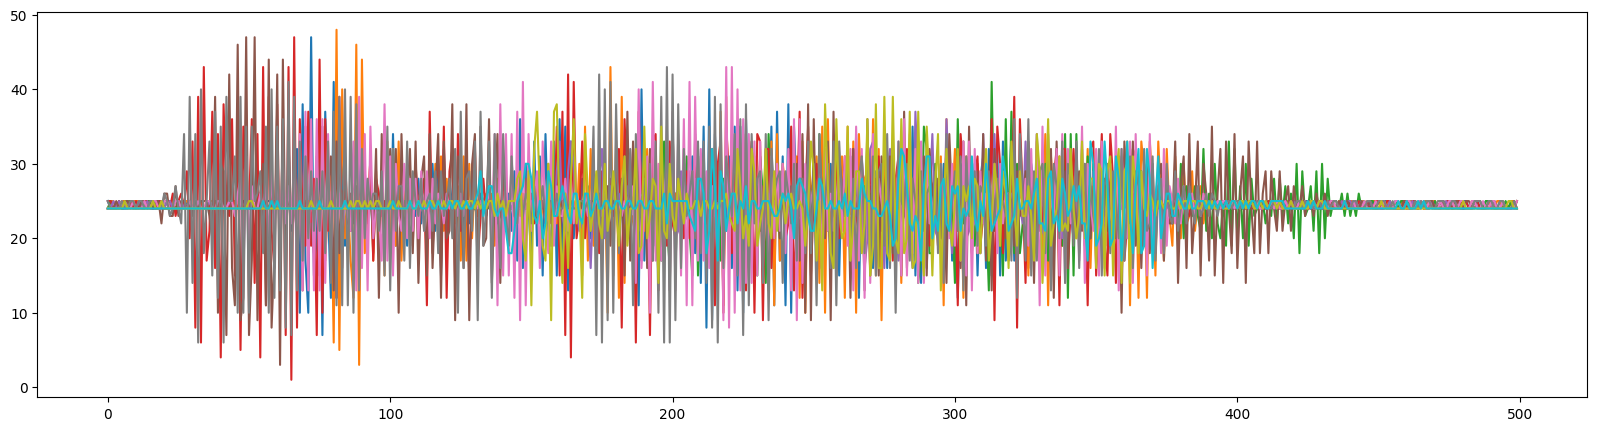

In [9]:
# plot the audio wave
plt.figure(figsize=(20,5))

for ts in X_train[:10]:
  plt.plot(ts)

plt.show()


# Classificatore di base: dummyclassifier

parto con un classificatore dummy per avere un punto di partenza con cui poter cofrontare i risultati che ottengo successivamente 

In [10]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train)

y_pred=dummy_clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.15384615384615385
F1-score [0.26666667 0.         0.         0.         0.         0.
 0.         0.        ]
              precision    recall  f1-score   support

       angry       0.15      1.00      0.27        96
        calm       0.00      0.00      0.00        96
     disgust       0.00      0.00      0.00        48
     fearful       0.00      0.00      0.00        96
       happy       0.00      0.00      0.00        96
     neutral       0.00      0.00      0.00        48
         sad       0.00      0.00      0.00        96
   surprised       0.00      0.00      0.00        48

    accuracy                           0.15       624
   macro avg       0.02      0.12      0.03       624
weighted avg       0.02      0.15      0.04       624



/Users/User/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/User/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/User/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [11]:
X_train.shape, y_train.shape

((1828, 500), (1828,))

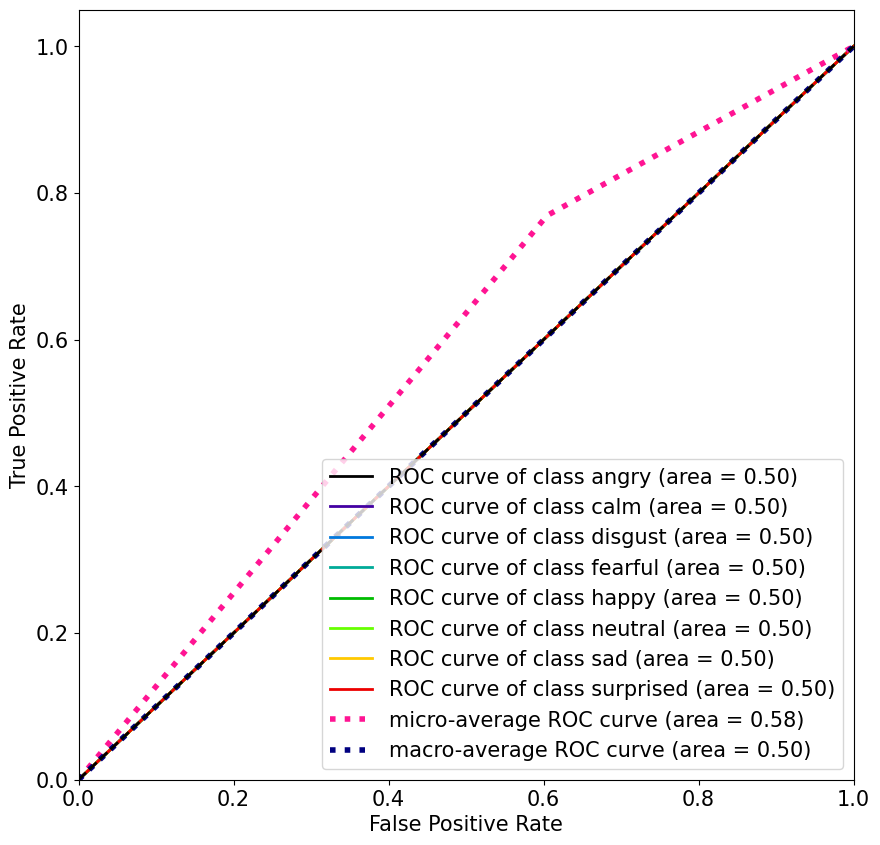

array([[96,  0,  0,  0,  0,  0,  0,  0],
       [96,  0,  0,  0,  0,  0,  0,  0],
       [48,  0,  0,  0,  0,  0,  0,  0],
       [96,  0,  0,  0,  0,  0,  0,  0],
       [96,  0,  0,  0,  0,  0,  0,  0],
       [48,  0,  0,  0,  0,  0,  0,  0],
       [96,  0,  0,  0,  0,  0,  0,  0],
       [48,  0,  0,  0,  0,  0,  0,  0]])

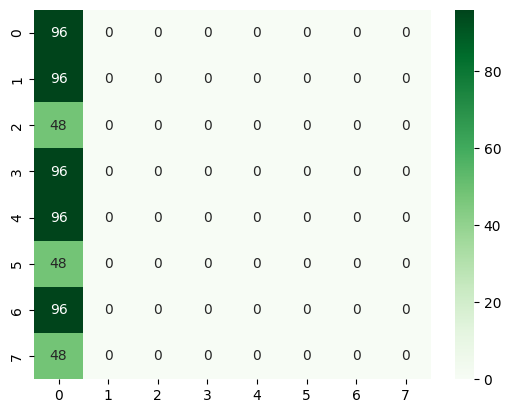

In [12]:
# ROC Curve
y_score_dummy = dummy_clf.predict_proba(X_test)
plot_roc(y_test, y_score_dummy, figsize=(10,10), title_fontsize=15, text_fontsize=15)
plt.title("")
plt.show()

#confusion matrix
cm_dummy = confusion_matrix(y_test, y_pred)
sns.heatmap(cm_dummy, annot=True, cmap="Greens")
cm_dummy

risultati sono molto merdosi, non c'è niente di buono (credo comunque debba venire così male perchè è dummy)

# Shaplet Classifiers

A shapelet is a subsequence of a time series which is highly discriminative to recognise among different classes.

### 1. Brute Force Approach - non importa eseguirlo, ho fatto il dummy perchè ci mette tanto ad eseguire il codice 

In [13]:
'''
from pyts.transformation import ShapeletTransform

# Shapelet transformation
st = ShapeletTransform(window_sizes="auto",
                       random_state=42, sort=True)
X_new = st.fit_transform(X_train, y_train)
X_test_new = st.transform(X_test)

from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth=8, random_state=42)
clf.fit(X_new, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))
'''


'\nfrom pyts.transformation import ShapeletTransform\n\n# Shapelet transformation\nst = ShapeletTransform(window_sizes="auto",\n                       random_state=42, sort=True)\nX_new = st.fit_transform(X_train, y_train)\nX_test_new = st.transform(X_test)\n\nfrom sklearn.tree import DecisionTreeClassifier\nclf = DecisionTreeClassifier(max_depth=8, random_state=42)\nclf.fit(X_new, y_train)\n\ny_pred = clf.predict(X_test)\n\nprint(\'Accuracy %s\' % accuracy_score(y_test, y_pred))\nprint(\'F1-score %s\' % f1_score(y_test, y_pred, average=None))\nprint(classification_report(y_test, y_pred))\n'

lo devo eseguire perchè ci vuole tanto tempo: 

### 2. Learning-based Approach


In [14]:
from keras.optimizers import Adagrad
from tslearn.shapelets import ShapeletModel
from tslearn.shapelets import grabocka_params_to_shapelet_size_dict

In [15]:
# numero ts and grandezza come quella di X train
n_ts, ts_sz = X_train.shape
# numero di classi, quelle della variabile target emotion
n_classes = len(set(y_train))

# Set the number of shapelets per size as done in the original paper
shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=n_ts,
                                                       ts_sz=ts_sz,
                                                       n_classes=n_classes,
                                                       l=0.1,
                                                       r=1)

print('n_ts', n_ts)
print('ts_sz', ts_sz)
print('n_classes', n_classes)
print('shapelet_sizes', shapelet_sizes)

n_ts 1828
ts_sz 500
n_classes 8
shapelet_sizes {50: 6}


<b>shapelet_sizes</b>: Questo è un dizionario che indica il numero di shapelet da estrarre per ciascuna lunghezza di shapelet. I shapelet sono sottosequenze significative delle serie temporali che possono aiutare nel processo di classificazione.

Abbiamo quindi ottenuto per una lunghezza di shapelets pari a 50, stiamo cercando di estrarre 6 shapelets.

In [16]:
# Build the model based on what we established before

#Define the model using parameters provided by the authors (except that we use fewer iterations here)
shp_clf = ShapeletModel(n_shapelets_per_size=shapelet_sizes,
                        optimizer="sgd",
                        weight_regularizer=.01,
                        max_iter=200,
                        verbose=1)

shp_clf

/Users/User/anaconda3/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


LearningShapelets(max_iter=200, n_shapelets_per_size={50: 6}, verbose=1,
                  weight_regularizer=0.01)

Per il .fit(), ho deciso che avremmo eseguito sul set di dati SAX invece che su quello originale perchè altrimenti ci avrebbe messo troppo tempo ad eseguire il codice 


In [17]:
# Addestriamo il modello sugli shapelets estratti dal training set
shp_clf.fit(X_train, y_train)

Epoch 1/200
8/8 [==============================] - 0s 14ms/step - loss: 357.1842 - categorical_accuracy: 0.1280 - categorical_crossentropy: 357.0619
Epoch 2/200
8/8 [==============================] - 0s 14ms/step - loss: 349.1035 - categorical_accuracy: 0.1554 - categorical_crossentropy: 348.9825
Epoch 3/200
8/8 [==============================] - 0s 13ms/step - loss: 366.1396 - categorical_accuracy: 0.1318 - categorical_crossentropy: 366.0106
Epoch 4/200
8/8 [==============================] - 0s 13ms/step - loss: 350.3423 - categorical_accuracy: 0.1532 - categorical_crossentropy: 350.2129
Epoch 5/200
8/8 [==============================] - 0s 13ms/step - loss: 374.7050 - categorical_accuracy: 0.1477 - categorical_crossentropy: 374.5909
Epoch 6/200
8/8 [==============================] - 0s 13ms/step - loss: 354.0524 - categorical_accuracy: 0.1351 - categorical_crossentropy: 353.9224
Epoch 7/200
8/8 [==============================] - 0s 13ms/step - loss: 309.7307 - categorical_accuracy: 0

LearningShapelets(max_iter=200, n_shapelets_per_size={50: 6}, verbose=1,
                  weight_regularizer=0.01)

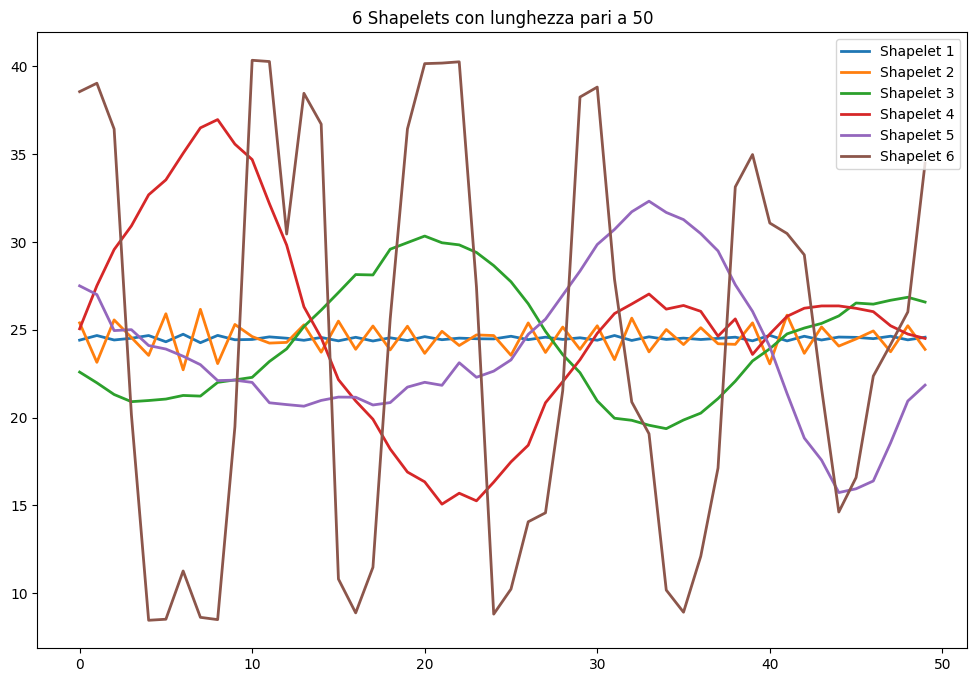

In [18]:
# Voglio visualizzare gli shapelets che sono venuti fuori 
shapelets = shp_clf.shapelets_
shapelets

# Visualize the shapelets
plt.figure(figsize=(12, 8))

# Plot each shapelet
for i, shapelet in enumerate(shapelets):
    plt.plot(shapelet.ravel(), label=f"Shapelet {i+1}", linewidth=2)

plt.legend()
plt.title("6 Shapelets con lunghezza pari a 50")
plt.show()

In [19]:
#Utilizziamo gli shapelets addestrati per predire le etichette delle serie temporali nel test set
y_pred = shp_clf.predict(X_test)

3/3 [==============================] - 0s 8ms/step


In [20]:
# osserviamo ora i risultati
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.07692307692307693
F1-score [0.         0.         0.14285714 0.         0.         0.
 0.         0.        ]
              precision    recall  f1-score   support

       angry       0.00      0.00      0.00        96
        calm       0.00      0.00      0.00        96
     disgust       0.08      1.00      0.14        48
     fearful       0.00      0.00      0.00        96
       happy       0.00      0.00      0.00        96
     neutral       0.00      0.00      0.00        48
         sad       0.00      0.00      0.00        96
   surprised       0.00      0.00      0.00        48

    accuracy                           0.08       624
   macro avg       0.01      0.12      0.02       624
weighted avg       0.01      0.08      0.01       624



/Users/User/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/User/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/User/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [==============================] - 0s 8ms/step


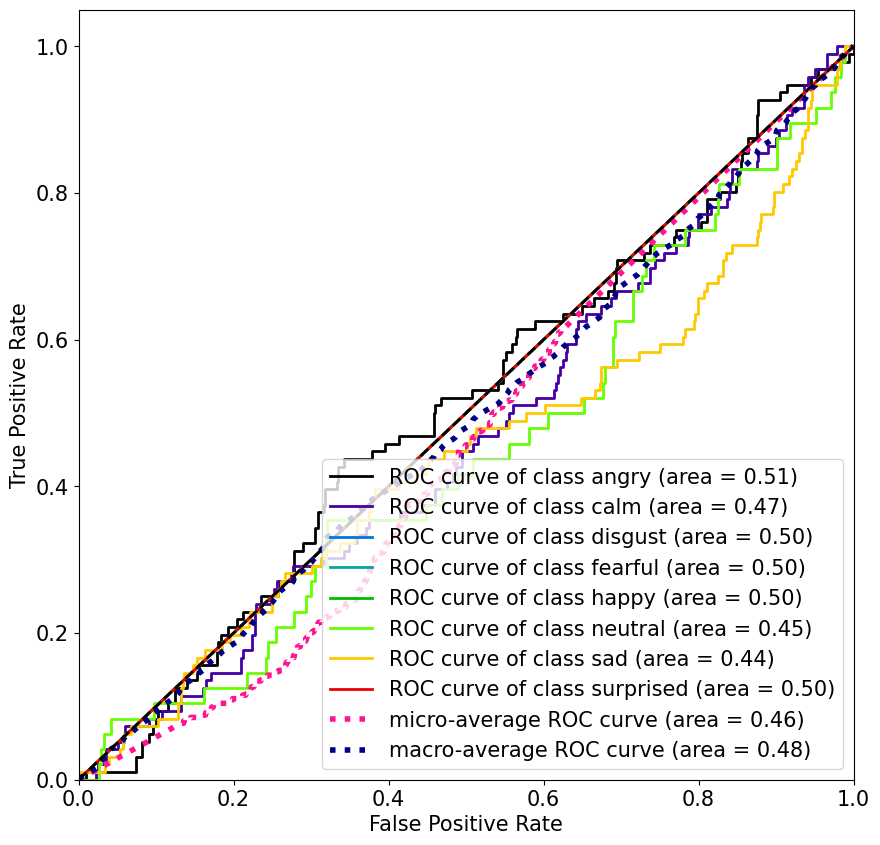

array([[ 0,  0, 96,  0,  0,  0,  0,  0],
       [ 0,  0, 96,  0,  0,  0,  0,  0],
       [ 0,  0, 48,  0,  0,  0,  0,  0],
       [ 0,  0, 96,  0,  0,  0,  0,  0],
       [ 0,  0, 96,  0,  0,  0,  0,  0],
       [ 0,  0, 48,  0,  0,  0,  0,  0],
       [ 0,  0, 96,  0,  0,  0,  0,  0],
       [ 0,  0, 48,  0,  0,  0,  0,  0]])

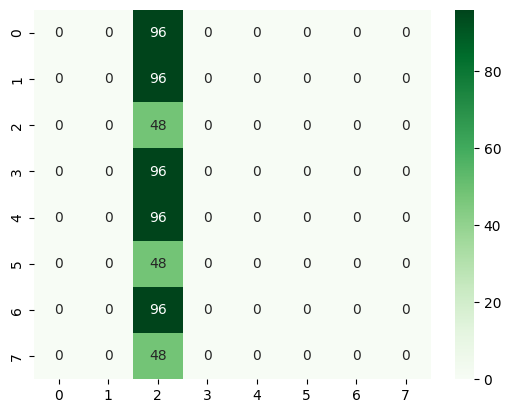

In [21]:
# ROC Curve
y_score_shp_clf = shp_clf.predict_proba(X_test)
plot_roc(y_test, y_score_shp_clf, figsize=(10,10), title_fontsize=15, text_fontsize=15)
plt.title("")
plt.show()

#confusion matrix
cm_shp_cls = confusion_matrix(y_test, y_pred)
sns.heatmap(cm_shp_cls, annot=True, cmap="Greens")
cm_shp_cls

RISULTATI: anche qui fanno abbastanza schifo perchè classifica solamente come emozione "sad" e le altre non le considera neanche, infatti i risultati sono uguali, giusto roc curve è forse un pochino migliore

In [22]:
# Voglio visualizzare gli shapelets che sono venuti fuori 
shapelets = shp_clf.shapelets_
shapelets

array([array([[24.40788841],
              [24.67052078],
              [24.4165287 ],
              [24.51581383],
              [24.66969681],
              [24.31428528],
              [24.74383926],
              [24.26167297],
              [24.67731857],
              [24.42896461],
              [24.4464016 ],
              [24.59340668],
              [24.51745224],
              [24.39843178],
              [24.55997086],
              [24.36747551],
              [24.57024765],
              [24.35892487],
              [24.54194641],
              [24.38276291],
              [24.60699272],
              [24.43198395],
              [24.52228737],
              [24.48758698],
              [24.47727966],
              [24.629179  ],
              [24.43560219],
              [24.57648468],
              [24.44879723],
              [24.54173851],
              [24.40275192],
              [24.67191315],
              [24.38920593],
              [24.59689522],
              

In [23]:
locator_model = shp_clf.locator_model_
locator_model

In [24]:
# Ottenere le predizioni sugli indici degli shapelets
shapelet_indices = locator_model.predict(X_test)
shapelet_indices.shape, shapelet_indices

# shapelet_indices conterrà gli indici degli shapelets per ogni serie temporale in X_test
# shapelet_indices avrà le dimensioni (n_timeseries, n_shapelets)


20/20 [==============================] - 0s 2ms/step


((624, 6),
 array([[245., 244., 179., 386., 203.,  37.],
        [255., 256., 391., 403.,  38.,  26.],
        [250., 306.,   6., 428., 142., 252.],
        ...,
        [280., 279., 238., 310.,  98., 370.],
        [ 39.,  62., 429.,  93., 152., 448.],
        [ 34.,  33., 285., 298.,  33., 291.]], dtype=float32))

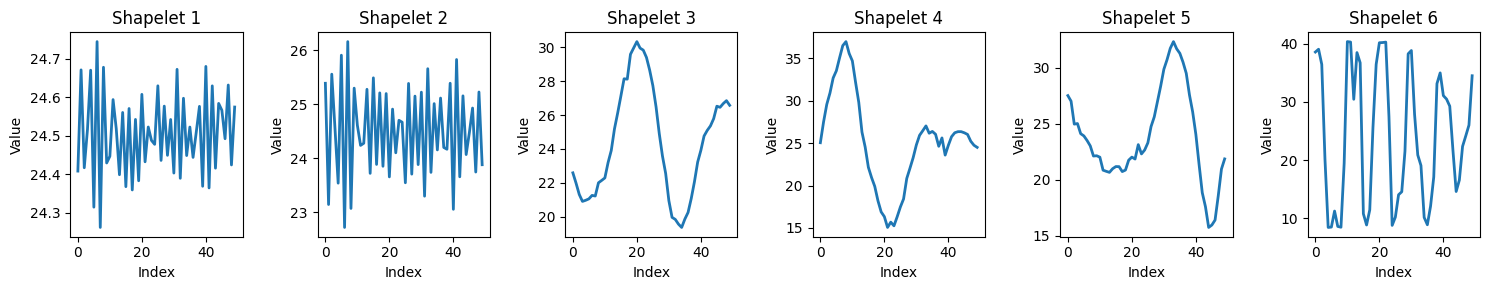

In [25]:
import matplotlib.pyplot as plt

# shapelets estratti dal modello
shapelets = shp_clf.shapelets_

# Numero di shapelets
num_shapelets = len(shapelets)

# Numero di righe e colonne per disporre i grafici
num_rows = 1
num_cols = num_shapelets

# Dimensione del grafico
plt.figure(figsize=(15, 3))

# Ciclo su ogni shapelet e lo disegna
for i, shapelet in enumerate(shapelets):
    plt.subplot(num_rows, num_cols, i+1)
    plt.plot(shapelet.ravel(), linewidth=2)
    plt.title(f"Shapelet {i+1}")
    plt.xlabel("Index")
    plt.ylabel("Value")

plt.tight_layout()
plt.show()


[[24.40788841]
 [24.67052078]
 [24.4165287 ]
 [24.51581383]
 [24.66969681]
 [24.31428528]
 [24.74383926]
 [24.26167297]
 [24.67731857]
 [24.42896461]
 [24.4464016 ]
 [24.59340668]
 [24.51745224]
 [24.39843178]
 [24.55997086]
 [24.36747551]
 [24.57024765]
 [24.35892487]
 [24.54194641]
 [24.38276291]
 [24.60699272]
 [24.43198395]
 [24.52228737]
 [24.48758698]
 [24.47727966]
 [24.629179  ]
 [24.43560219]
 [24.57648468]
 [24.44879723]
 [24.54173851]
 [24.40275192]
 [24.67191315]
 [24.38920593]
 [24.59689522]
 [24.44818497]
 [24.52216911]
 [24.4434433 ]
 [24.50903511]
 [24.57585144]
 [24.36849785]
 [24.67949104]
 [24.36417389]
 [24.62906647]
 [24.41545105]
 [24.58346939]
 [24.56572342]
 [24.49187279]
 [24.63123322]
 [24.42383575]
 [24.57409286]]
FINE SHAPELET_1 


[[25.39130211]
 [23.14300728]
 [25.56029701]
 [24.5593071 ]
 [23.53890419]
 [25.91215515]
 [22.71767807]
 [26.16404533]
 [23.07003784]
 [25.30114746]
 [24.61167908]
 [24.23921967]
 [24.27908897]
 [25.27975273]
 [23.72088814]
 [25.

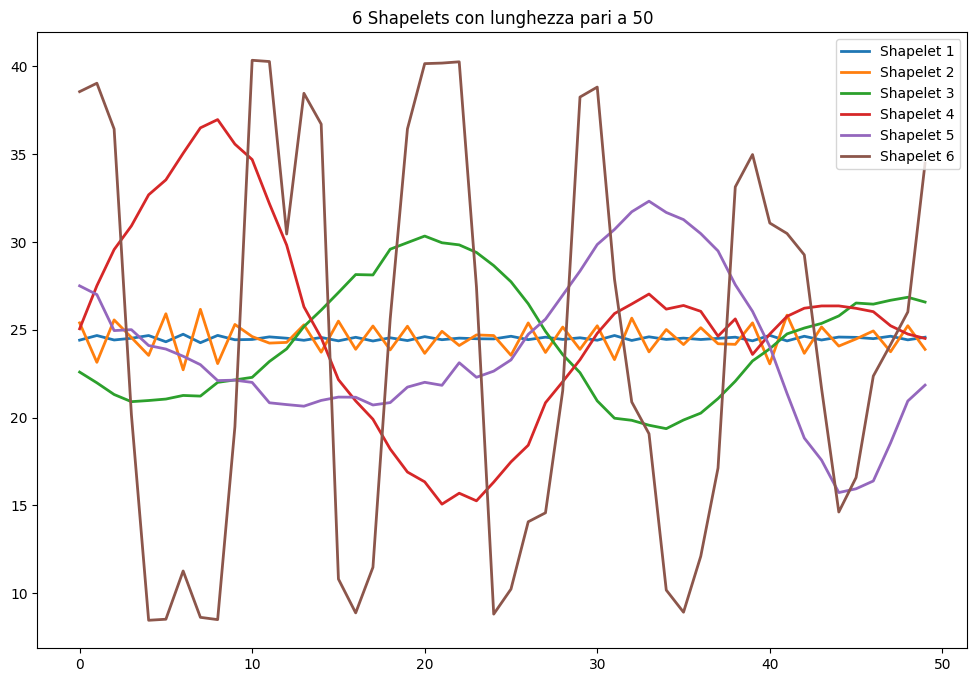

In [142]:
# Visualize the shapelets
plt.figure(figsize=(12, 8))

# Plot each shapelet
for i, shapelet in enumerate(shapelets):
    plt.plot(shapelet.ravel(), label=f"Shapelet {i+1}", linewidth=2)
    print(shapelet)
    print(f"FINE SHAPELET_{i+1} \n\n")
plt.legend()
plt.title("6 Shapelets con lunghezza pari a 50")
plt.show()

### 3. Shapelets Distances-Based Classifier

In [27]:
#trasformo in shapelets il dataset di time series - TRAIN
X_train2 = shp_clf.transform(X_train)
X_train2.shape, X_train2

8/8 [==============================] - 0s 9ms/step


((1828, 6),
 array([[  0.22976562,   0.7598437 ,  10.086172  ,  31.495625  ,
          17.2325    , 127.18555   ],
        [  0.23859374,   0.761875  ,  10.144062  ,  31.51914   ,
          17.121407  , 127.057106  ],
        [  0.23789062,   0.77335936,  10.166953  ,  31.818594  ,
          17.178593  , 127.15242   ],
        ...,
        [  0.221875  ,   0.7021875 ,   9.725547  ,  30.805311  ,
          17.1225    , 110.53234   ],
        [  0.23546875,   0.7530469 ,  10.196796  ,  31.337343  ,
          17.785625  , 120.21945   ],
        [  0.23789062,   0.75742185,   9.985391  ,  31.41328   ,
          16.987656  , 114.70367   ]], dtype=float32))

In [28]:
#trasformo in shapelets il dataset di time series - TEST
X_test2 = shp_clf.transform(X_test)
X_test2.shape, X_test2

3/3 [==============================] - 0s 8ms/step


((624, 6),
 array([[  0.2084375 ,   0.5110156 ,   9.969687  ,  30.323046  ,
          17.243202  , 126.73398   ],
        [  0.223125  ,   0.689375  ,   9.841953  ,  30.868515  ,
          17.014141  , 122.51859   ],
        [  0.218125  ,   0.6294531 ,  10.257969  ,  30.531717  ,
          17.588827  , 127.21078   ],
        ...,
        [  0.21609375,   0.6178906 ,  10.239922  ,  31.575312  ,
          17.3125    , 126.20984   ],
        [  0.21429688,   0.6220312 ,  10.072422  ,  31.395546  ,
          17.407187  , 126.066635  ],
        [  0.21546875,   0.64742184,  10.17914   ,  31.531406  ,
          17.668047  , 126.185936  ]], dtype=float32))

KNN

Qui utilizzo gli shapelets che ho trovato prima per valutare le prestazioni del modello di classificazione attraverso un KNN

--> per adesso ho lasciato tutti i parametri come sono già impostati, se poi c'è più tempo magari faccio una randomized search 

In [29]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier

#Facciamo una randomized search with 5-cross fold validation - caso knn con distanza manhattan/euclidea (che viene scelta nella cross validation)
param_dist = {
    'n_neighbors': (1, 3, 5, 7, 9, 10, 15, 30, 50),  # Number of neighbors
    'weights': ['uniform', 'distance'],  # Weight function used in prediction
    'p': [1, 2],  # Power parameter for the Minkowski metric (1: Manhattan distance, 2: Euclidean distance)
}

knn=KNeighborsClassifier()
random_search = RandomizedSearchCV(knn, param_distributions=param_dist, n_iter=10, cv=5, random_state=42)
random_search.fit(X_train2, y_train)
random_search.best_params_


{'weights': 'distance', 'p': 2, 'n_neighbors': 50}

In [30]:
from sklearn.neighbors import KNeighborsClassifier
# clf = KNeighborsClassifier(n_neighbors=5, weights='uniform', metric='euclidean') -->base di guidotti 
clf = KNeighborsClassifier(n_neighbors=50, weights='distance', p=2,  metric='euclidean', n_jobs=-1) # --> quello che viene fuori dalla randomized_search()
clf.fit(X_train2, y_train)

y_pred = clf.predict(X_test2)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.14423076923076922
F1-score [0.         0.22742475 0.         0.06722689 0.01904762 0.06593407
 0.22170901 0.        ]
              precision    recall  f1-score   support

       angry       0.00      0.00      0.00        96
        calm       0.17      0.35      0.23        96
     disgust       0.00      0.00      0.00        48
     fearful       0.17      0.04      0.07        96
       happy       0.11      0.01      0.02        96
     neutral       0.07      0.06      0.07        48
         sad       0.14      0.50      0.22        96
   surprised       0.00      0.00      0.00        48

    accuracy                           0.14       624
   macro avg       0.08      0.12      0.08       624
weighted avg       0.10      0.14      0.09       624



/Users/User/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/User/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/User/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [==============================] - 0s 9ms/step


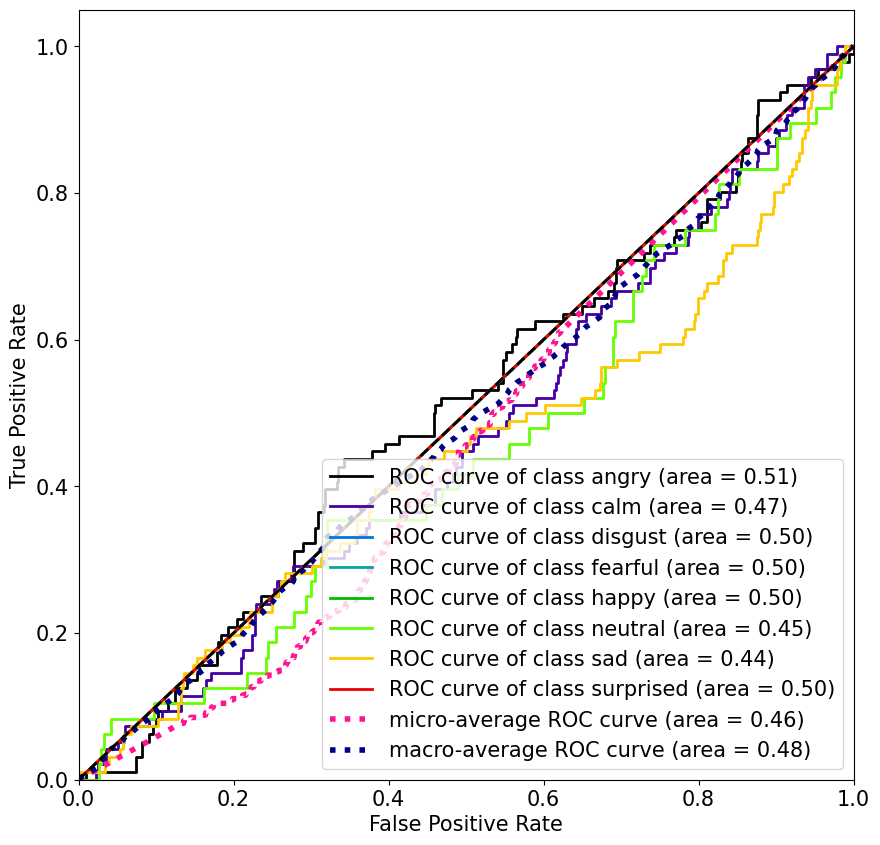

array([[ 0, 26,  0,  0,  3,  9, 58,  0],
       [ 1, 34,  1,  3,  2,  7, 48,  0],
       [ 0, 15,  0,  1,  0,  4, 28,  0],
       [ 1, 28,  0,  4,  2,  3, 58,  0],
       [ 3, 29,  3,  5,  1, 10, 45,  0],
       [ 0, 19,  0,  3,  0,  3, 23,  0],
       [ 0, 40,  0,  3,  1,  4, 48,  0],
       [ 0, 12,  0,  4,  0,  3, 29,  0]])

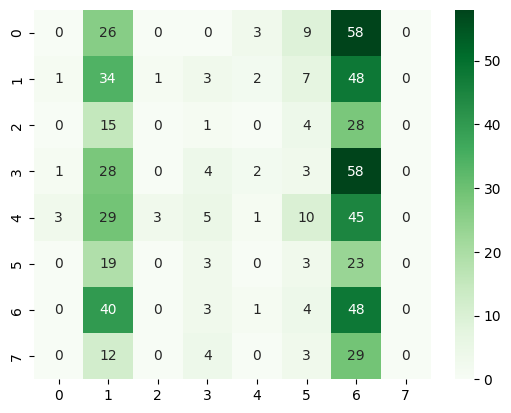

In [31]:
# ROC Curve
y_score_shp_clf = shp_clf.predict_proba(X_test)
plot_roc(y_test, y_score_shp_clf, figsize=(10,10), title_fontsize=15, text_fontsize=15)
plt.title("")
plt.show()

#confusion matrix
cm_shp_cls = confusion_matrix(y_test, y_pred)
sns.heatmap(cm_shp_cls, annot=True, cmap="Greens")
cm_shp_cls

DECISION TREE

Qui utilizzo gli shapelets che ho trovato prima per valutare le prestazioni del modello di classificazione attraverso un Decision Tree

In [32]:
# Definisci la griglia dei parametri che vuoi testare
from random import randint
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()

param_dist = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [6, 8, 10, 12, 14, 16, 18, 20],  # Specifica l'intervallo degli iperparametri numerici
}

# Esegui la ricerca randomizzata
random_search = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=10, cv=5, random_state=42)
random_search.fit(X_train2, y_train)
random_search.best_params_

{'max_depth': 6, 'criterion': 'entropy'}

In [33]:
from sklearn.tree import DecisionTreeClassifier

#clf = DecisionTreeClassifier(max_depth=8, random_state=42) # --> default di Guidotti
clf = DecisionTreeClassifier(max_depth=6, criterion='entropy',random_state=42) # --> parametri della randomized_search()
clf.fit(X_train2, y_train)

y_pred = clf.predict(X_test2)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.14262820512820512
F1-score [0.         0.22485207 0.16066482 0.12359551 0.20454545 0.03846154
 0.14193548 0.        ]
              precision    recall  f1-score   support

       angry       0.00      0.00      0.00        96
        calm       0.26      0.20      0.22        96
     disgust       0.09      0.60      0.16        48
     fearful       0.13      0.11      0.12        96
       happy       0.23      0.19      0.20        96
     neutral       0.25      0.02      0.04        48
         sad       0.19      0.11      0.14        96
   surprised       0.00      0.00      0.00        48

    accuracy                           0.14       624
   macro avg       0.14      0.15      0.11       624
weighted avg       0.15      0.14      0.12       624



/Users/User/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/User/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/User/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [==============================] - 0s 8ms/step


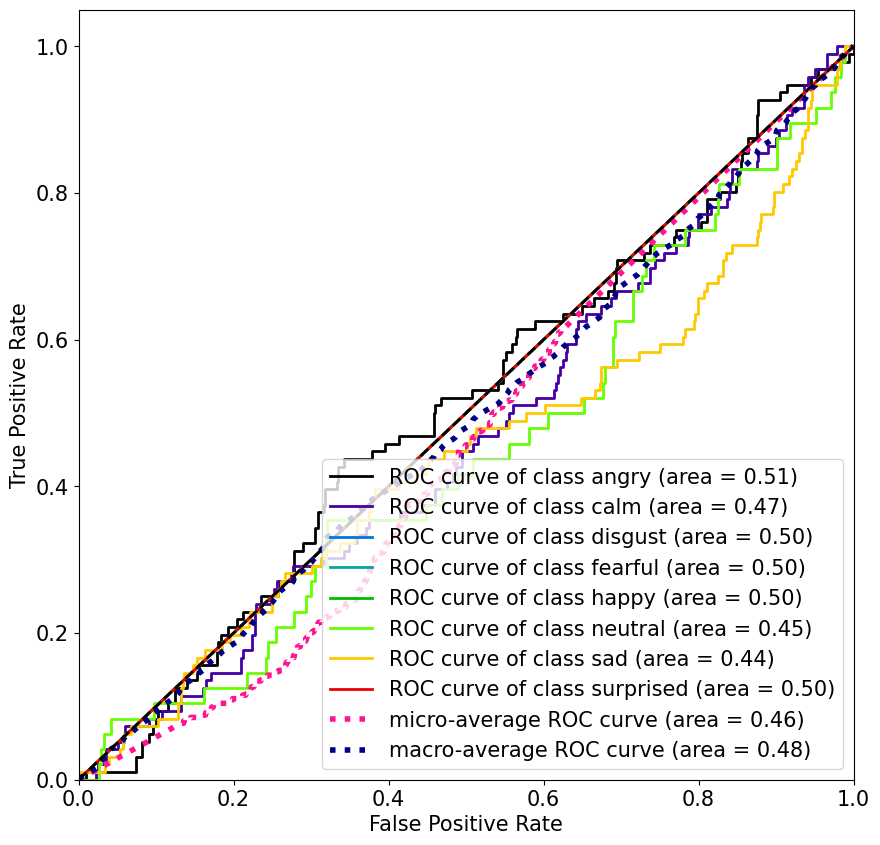

array([[ 0,  8, 55, 12, 14,  0,  7,  0],
       [ 1, 19, 42,  9, 10,  1, 14,  0],
       [ 1,  3, 29, 10,  1,  0,  4,  0],
       [ 1, 12, 52, 11, 10,  1,  9,  0],
       [ 5, 12, 45,  9, 18,  0,  7,  0],
       [ 1,  3, 22,  8,  9,  1,  4,  0],
       [ 2,  9, 49, 15,  9,  1, 11,  0],
       [ 2,  7, 19,  8,  9,  0,  3,  0]])

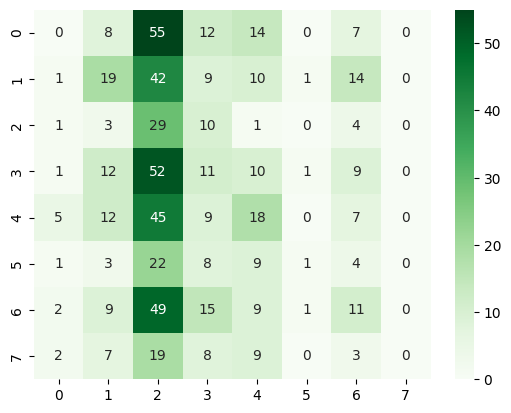

In [34]:
# ROC Curve
y_score_shp_clf = shp_clf.predict_proba(X_test)
plot_roc(y_test, y_score_shp_clf, figsize=(10,10), title_fontsize=15, text_fontsize=15)
plt.title("")
plt.show()

#confusion matrix
cm_shp_cls = confusion_matrix(y_test, y_pred)
sns.heatmap(cm_shp_cls, annot=True, cmap="Greens")
cm_shp_cls

CONCLUSIONI: nessuno dei seguenti classificatori è comunque buono perchè le prestazioni non sono il massimo. 

# Comparison btw shapelets and motifs/discords

Gli indici degli shapelets e i valori degli shapelets rappresentano informazioni diverse. Gli indici degli shapelets indicano la posizione degli shapelets nei dati temporali originali, mentre i valori degli shapelets sono i valori stessi degli shapelets estratti.

Per confrontare gli shapelets con i motifs, dovresti utilizzare gli indici degli shapelets. Gli indici sono importanti perché ti dicono dove si trovano gli shapelets nei tuoi dati originali. Puoi utilizzare questi indici per trovare le corrispondenze tra gli shapelets e i motifs, e successivamente calcolare le distanze o le similarità tra gli shapelets e i motifs.

Quindi, nel tuo caso, dovresti considerare gli indici degli shapelets per il confronto con gli indici dei motifs. Puoi ignorare i valori degli shapelets durante il confronto, a meno che non sia necessario confrontare anche i valori specifici. La scelta tra distanza euclidea o un'altra misura di similarità dipende dai requisiti specifici del tuo progetto e dall'interpretazione che desideri dare ai risultati del confronto.

In [112]:
# Riprendo gli INDICI degli shapeltes --> MI SERVONO per fare il CONFRONTO
type(shapelet_indices), shapelet_indices

(numpy.ndarray,
 array([[245., 244., 179., 386., 203.,  37.],
        [255., 256., 391., 403.,  38.,  26.],
        [250., 306.,   6., 428., 142., 252.],
        ...,
        [280., 279., 238., 310.,  98., 370.],
        [ 39.,  62., 429.,  93., 152., 448.],
        [ 34.,  33., 285., 298.,  33., 291.]], dtype=float32))

In [133]:
print("Forma dell'array:", shapelet_indices.shape)
print("Tipo di dati dell'array:", shapelet_indices.dtype)

Forma dell'array: (624, 6)
Tipo di dati dell'array: float32


Ho ottenuto i motifs utilizzando la funzione motifs.motifs con la libreria che sto usando e ho ottenuto due tuple: mo e mod:
- mo: contiene gli indici dei motifs
- mod: contiene i valori dei motifs

Quindi, per confrontare gli shapelets con i motifs utilizzando gli indici, utilizzo gli indici mo e confrontarli con gli indici degli shapelets. Una volta trovato il motif corrispondente per ciascuno shapelet, calcolo la distanza tra lo shapelet e il motif corrispondente.

In [92]:
# Considero l'approssimazione SAX con DTW, con una finestra w=10 sulla time series 811

# Riprendo gli INDICI dei motifs: MI SERVONO per fare il CONFRONTO
mo = ([[29, 73],
  [6, 167],
  [16, 147],
  [104, 178],
  [124, 243],
  [161, 272],
  [186, 192],
  [44, 231, 249],
  
  [98, 115]])
type(mo), mo

(list,
 [[29, 73],
  [6, 167],
  [16, 147],
  [104, 178],
  [124, 243],
  [161, 272],
  [186, 192],
  [44, 231, 249],
  [98, 115]])

In [165]:
# converto da lista a np.array, con lunghezza massima la lunghezza del motifs più lungo
from itertools import zip_longest
import numpy as np

mo = [
      [29, 73],
      [6, 167],
      [16, 147],
      [104, 178],
      [124, 243],
      [161, 272],
      [186, 192],
      [44, 231, 249] 
     ]

# Trova la lunghezza massima tra le liste in mo
max_length = max(len(sublist) for sublist in mo)

# Riempie le liste più corte con un valore di riempimento
mo_padded = [sublist + [0] * (max_length - len(sublist)) for sublist in mo]

# Converti la lista di liste in un array NumPy
mo = np.array(mo_padded)
type(mo), mo


(numpy.ndarray,
 array([[ 29,  73,   0],
        [  6, 167,   0],
        [ 16, 147,   0],
        [104, 178,   0],
        [124, 243,   0],
        [161, 272,   0],
        [186, 192,   0],
        [ 44, 231, 249]]))

In [166]:
print("Forma dell'array:", mo.shape)
print("Tipo di dati dell'array:", mo.dtype)
print("Elementi dell'array: \n", mo[:])

Forma dell'array: (8, 3)
Tipo di dati dell'array: int64
Elementi dell'array: 
 [[ 29  73   0]
 [  6 167   0]
 [ 16 147   0]
 [104 178   0]
 [124 243   0]
 [161 272   0]
 [186 192   0]
 [ 44 231 249]]


In [173]:
# Riprendo il VALORE dei motifs --> NON MI SERVE per fare il confronto
mod = ([2.132480599880018e-06,
  0.6448372687949829,
  0.7051744974714588,
  0.742781334143556,
  0.8168706546987455,
  0.8221414653499335,
  0.8552672533334029,
  0.9690269196033703,
  1.0304416130373024])
mod

[2.132480599880018e-06,
 0.6448372687949829,
 0.7051744974714588,
 0.742781334143556,
 0.8168706546987455,
 0.8221414653499335,
 0.8552672533334029,
 0.9690269196033703,
 1.0304416130373024]

In [109]:
'''
# Riprendo i VALORI dei 6 shapelets --> NON MI SERVONO per fare il confronto

shapelets = shp_clf.shapelets_
shapelets
'''

'\n# Riprendo i VALORI dei 6 shapelets --> NON MI SERVONO per fare il confronto\n\nshapelets = shp_clf.shapelets_\nshapelets\n'

Adesso che ho i due diversi np.array che hanno gli indici, devo fare un confronto tra i due, in modo da trovare per ogni indice degli shapelets, quale è il motifs che più gli è vicino. 

Negli shapelet_indices, so che conterrà gli indici degli shapelets per ogni serie temporale in X_test e che avrà le dimensioni (n_timeseries, n_shapelets): ci sono 6 shapelets che hanno diversi indici all'interno, una lista di lista per ciascuno


Nei mo, so che ha la forma (top_motifs, distances), dove 
- top_motifs: indices found for each motif. The first index is the nth motif followed by all nearest neighbors found sorted by distances.
- distances: Minimum Matrix profile value for each motif set.

In [195]:
import numpy as np
import matplotlib.pyplot as plt

# Inizializza la matrice delle distanze
distances = np.zeros((len(shapelet_indices), len(mo)))

for i, shapelet in enumerate(shapelet_indices):
    for j, motif_indices in enumerate(mo):
        # Inizializza una lista vuota per memorizzare i valori del motif
        motif_values = []
        
        # Itera attraverso gli indici del motif
        for index in motif_indices:
            # Controlla se l'indice è valido e ottieni il valore corrispondente
            if index < len(mo):
                motif_values.append(mod[index])
        
        # Calcola la media dei valori del motif
        motif = np.mean(motif_values, axis=0)
        
        # Calcola la distanza euclidea tra lo shapelet e il motif
        distances[i, j] = np.linalg.norm(shapelet - motif)

# Sostituisci i valori NaN con 0 nella matrice
distances = np.nan_to_num(distances)

# Ora hai calcolato le distanze tra gli shapelet e i motifs

# Calcola le medie delle distanze tra gli shapelet e i motifs
mean_distances = np.mean(distances, axis=1)

# Stampa le distanze calcolate
print("Distanze tra shapelets e motifs: \n", distances)


Distanze tra shapelets e motifs: 
 [[585.81225586 584.86779785 585.81225586 ... 585.81225586 585.81225586
    0.        ]
 [669.30633545 668.43188477 669.30633545 ... 669.30633545 669.30633545
    0.        ]
 [650.4029541  649.49316406 650.4029541  ... 650.4029541  650.4029541
    0.        ]
 ...
 [674.89923096 673.90136719 674.89923096 ... 674.89923096 674.89923096
    0.        ]
 [649.50982666 648.70495605 649.50982666 ... 649.50982666 649.50982666
    0.        ]
 [507.98031616 507.1607666  507.98031616 ... 507.98031616 507.98031616
    0.        ]]


Distanze tra shapelets e motifs:
[[585.81225586 584.86779785 585.81225586 ... 585.81225586 585.81225586
    0.        ]
 [669.30633545 668.43188477 669.30633545 ... 669.30633545 669.30633545
    0.        ]
 [650.4029541  649.49316406 650.4029541  ... 650.4029541  650.4029541
    0.        ]
 ...
 [674.89923096 673.90136719 674.89923096 ... 674.89923096 674.89923096
    0.        ]
 [649.50982666 648.70495605 649.50982666 ... 649.50982666 649.50982666
    0.        ]
 [507.98031616 507.1607666  507.98031616 ... 507.98031616 507.98031616
    0.        ]]


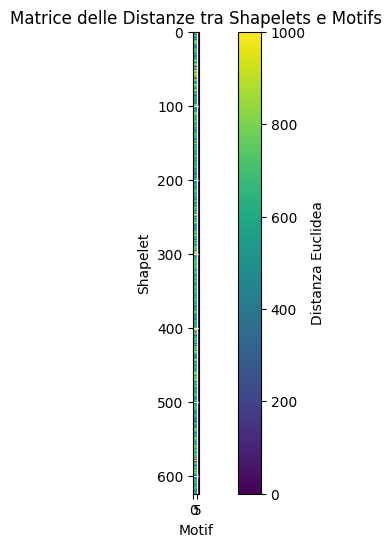

In [184]:
import numpy as np
import matplotlib.pyplot as plt

# Inizializza la matrice delle distanze
distances = np.zeros((len(shapelet_indices), len(mo)))

for i, shapelet in enumerate(shapelet_indices):
    for j, motif_indices in enumerate(mo):
        # Inizializza una lista vuota per memorizzare i valori del motif
        motif_values = []
        
        # Itera attraverso gli indici del motif
        for index in motif_indices:
            # Controlla se l'indice è valido e ottieni il valore corrispondente
            if index < len(mod):
                motif_values.append(mod[index])
        
        # Calcola la media dei valori del motif
        motif = np.mean(motif_values, axis=0)
        
        # Calcola la distanza euclidea tra lo shapelet e il motif
        distances[i, j] = np.linalg.norm(shapelet - motif)

# Sostituisci i valori NaN con 0 nella matrice
distances = np.nan_to_num(distances)

# Stampa le distanze calcolate
print("Distanze tra shapelets e motifs:")
print(distances)

# Genera un grafico a colori per visualizzare la matrice delle distanze
plt.figure(figsize=(10, 6))
plt.imshow(distances, cmap='viridis', interpolation='nearest')

# Aggiungi una griglia bianca per distanziare le celle
plt.grid(color='white')

plt.colorbar(label='Distanza Euclidea')
plt.xlabel('Motif')
plt.ylabel('Shapelet')
plt.title('Matrice delle Distanze tra Shapelets e Motifs')
plt.show()
